### Import modules and read data

In [32]:
import json
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pandas as pd
import powerlaw

In [2]:
# df = pd.read_csv(os.getcwd() + '/Data/us_states_clean.csv').drop(columns = ['Unnamed: 0'])
df = pd.read_csv(os.getcwd() + '/Data/us_counties_clean.csv').drop(columns = ['Unnamed: 0'])
df['date'] = pd.to_datetime(df['date'])
df.shape

(1793909, 7)

In [3]:
df.tail()

,date,county,fips,cases,deaths,new_cases,new_deaths
1793904,2021-10-31,"Sweetwater County, WY",56037.0,7575,80.0,0.0,0.0
1793905,2021-10-31,"Teton County, WY",56039.0,5204,14.0,0.0,0.0
1793906,2021-10-31,"Uinta County, WY",56041.0,3829,26.0,0.0,0.0
1793907,2021-10-31,"Washakie County, WY",56043.0,1730,35.0,0.0,0.0
1793908,2021-10-31,"Weston County, WY",56045.0,1109,9.0,0.0,0.0


### Correlation Network Creator

In [4]:
def create_correlation_network(df, start_date, end_date, threshold, pivot_cols = 'county', pivot_vals = 'new_cases'):
    """Create a network based on correlation values
    Parameters:
        df (pd.DataFrame): the data
        start_date (str): the date to start from as an ISO 8601 date string
        end__date (str): the date to end on as an ISO 8601 date string
        threshold (int): the minimum correlation value
        pivot_cols (str): the column to pivot on (default: county)
        pivot_vals (str): the values for the pivot columns (default: new_cases)
    Returns:
        pd.DataFrame: an edge list as a DataFrame"""
    
    df = df[(df['date'] >= start_date) & (df['date'] <= end_date)]  # filter on dates
#     print('Start date:', start_date)
    
    df_corrs = df.pivot(index = 'date', columns = pivot_cols, values = pivot_vals).corr()  # calculate correlations
#     print('Correlation matrix shape:', df_corrs.shape)
    
    # get edge list
    links = pd.DataFrame(df_corrs.values, columns = df_corrs.columns.values).set_index(keys = df_corrs.columns.values).stack().reset_index()
    links.rename(columns = {'level_0': 'var1', 'level_1': 'var2', 0: 'weight'}, inplace = True)
    
    return links.loc[(links['weight'] > threshold) & (links['var1'] != links['var2'])]

### Network Growth

In [5]:
def growth_rate(dates, delta = 5):
    """Create a data frame of graph growth
    Parameters:
        dates (pd.DatetimeIndex): the start dates
        delta (int): the day delta for end dates (default: 5)
    Returns:
        pd.DataFrame: a graph growth data frame"""
    
    n_nodes, n_edges = [], []
    
    for d in dates:
        corr_g = nx.from_pandas_edgelist(create_correlation_network(df, d, d + pd.Timedelta(delta, unit = 'D'), 0.5), 'var1', 'var2')
        
        n_nodes.append(len(corr_g))
        n_edges.append(len(corr_g.edges))
        
    return pd.DataFrame([dates, n_nodes, n_edges]).T.rename(columns = {0: 'date', 1: 'nodes', 2: 'edges'})

In [6]:
growth_df = growth_rate(pd.date_range(start = '2020-02-15', end = '2020-04-30', freq = '5D'))
growth_df

,date,nodes,edges
0,2020-02-15,0,0
1,2020-02-20,2,1
2,2020-02-25,7,7
3,2020-03-01,21,53
4,2020-03-06,76,707
5,2020-03-11,237,7689
6,2020-03-16,540,46901
7,2020-03-21,1054,161623
8,2020-03-26,1552,243178
9,2020-03-31,1962,357646


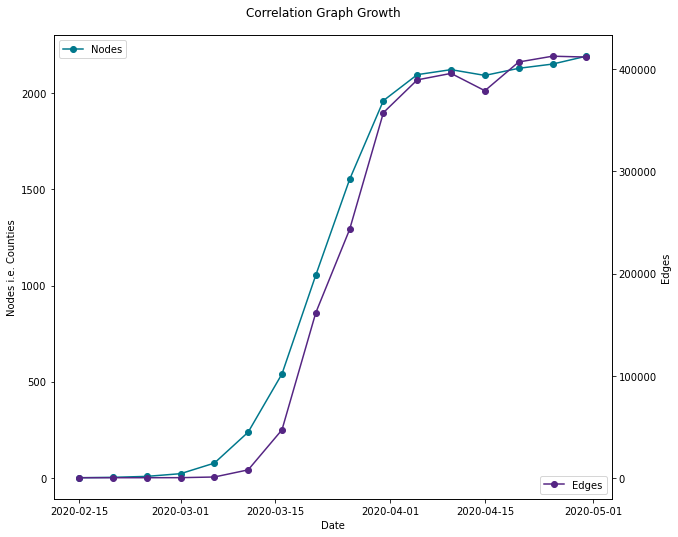

In [7]:
fig, ax1 = plt.subplots(figsize = (10, 8))
fig.suptitle('Correlation Graph Growth')

ax1.plot(growth_df['date'], growth_df['nodes'], marker = 'o', color = '#00788c', label = 'Nodes')
ax1.set_xlabel('Date')
ax1.set_ylabel('Nodes i.e. Counties')
plt.legend(loc = 2)

ax2 = ax1.twinx()
ax2.plot(growth_df['date'], growth_df['edges'], marker = 'o', color = '#552583', label = 'Edges')
ax2.set_ylabel('Edges')
plt.legend(loc = 4)

plt.subplots_adjust(top = 0.93)
plt.show()
plt.close()

### Creating some networks for further analysis

In [8]:
# dec20_counties_cases = nx.from_pandas_edgelist(create_correlation_network(df, '2020-12-01', '2020-12-31', 0.75), 'var1', 'var2', 'weight')
# nx.info(dec20_counties_cases)

In [9]:
# may20_counties_cases = nx.from_pandas_edgelist(create_correlation_network(df, '2020-05-01', '2020-05-31', 0.75), 'var1', 'var2', 'weight')
# nx.info(may20_counties_cases)

In [10]:
all_data_G = nx.from_pandas_edgelist(create_correlation_network(df, '2020-02-01', '2020-10-31', 0.75), 'var1', 'var2', 'weight')
nx.info(all_data_G)

'Graph with 929 nodes and 5566 edges'

In [11]:
def degree_distro(G, name) -> None:
    """Plot the degree distro of a network
    Parameters:
        G (nx.Graph): a network
        name (str): network name
    Returns:
        None"""
    
    degrees = np.array(list(dict(G.degree()).values()))
    k_min, k_max = min(degrees), max(degrees)
    
    bin_edges = np.logspace(np.log10(k_min), np.log10(k_max), num = 20)
    density, _ = np.histogram(degrees, bins = bin_edges, density = True)
    
    log_be = np.log10(bin_edges)
    x = 10 ** ((log_be[: -1] + log_be[1 :]) / 2)
    
    fig, ax = plt.subplots(figsize = (10, 8))
    plt.loglog(x, density, marker = 'o', ls = 'none', color = '#552583')
    plt.title('{} Degree Distribution'.format(name))
    plt.xlabel('Degree k')
    plt.ylabel('Density p(k)')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.show()
    plt.close()

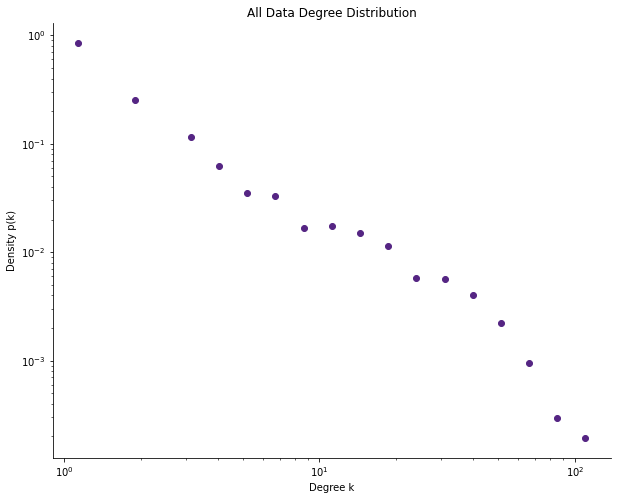

In [12]:
degree_distro(all_data_G, 'All Data')

In [13]:
# degree_distro(dec20_counties_cases, "Dec'20 Counties - Cases Network")

In [14]:
# degree_distro(may20_counties_cases, "May'20 Counties - Cases Network")

In [15]:
def fit_powerlaw(G) -> float:
    """Fit a power law and calculate the degree exponent of a network
    Parameters:
        G (nx.Graph): the network
    Returns:
        float: the degree exponent gamma"""
    
    degrees = np.array(list(dict(G.degree()).values()))
    
    res = powerlaw.Fit(degrees, discrete = True)
    print('Gamma:', res.power_law.alpha)
    
    return res.power_law.alpha

In [16]:
fit_powerlaw(all_data_G)

Calculating best minimal value for power law fit
Gamma: 4.057056417417066


4.057056417417066

In [17]:
# fit_powerlaw(may20_counties_cases)

In [18]:
# fit_powerlaw(dec20_counties_cases)

In [33]:
states_info = {}

with open('./Data/usa-state-data.json', 'r') as state_json:
    states_info = json.load(state_json)

len(states_info)

51

In [36]:
nx.set_node_attributes(all_data_G, {c: c.split(',')[1].strip() for c in list(all_data_G.nodes)}, 'State')
nx.set_node_attributes(all_data_G, {c: states_info[c.split(',')[1].strip()]['region'] for c in list(all_data_G.nodes)}, 'Region')

all_data_G.nodes['Suffolk County, MA']

{'State': 'MA', 'Region': 'Northeast'}

In [37]:
nx.write_gml(all_data_G, './Graphs/all_data_corr.gml')

In [20]:
# nx.write_gml(may20_counties_cases, './Graphs/may20_counties_cases_corr.gml')

In [21]:
# feb_counties_cases = nx.from_pandas_edgelist(create_correlation_network(df, '2020-02-01', '2020-02-29', 0.5), 'var1', 'var2', 'weight')
# nx.info(feb_counties_cases)

# feb_counties_cases.edges(data = True)

# april_counties_cases = nx.from_pandas_edgelist(create_correlation_network(df, '2020-04-01', '2020-04-30', 0.5), 'var1', 'var2')
# nx.info(april_counties_cases)

# march_1_counties_cases = nx.from_pandas_edgelist(create_correlation_network(df, '2020-03-01', '2020-03-10', 0.5), 'var1', 'var2')
# march_11_counties_cases = nx.from_pandas_edgelist(create_correlation_network(df, '2020-03-11', '2020-03-20', 0.5), 'var1', 'var2')
# march_21_counties_cases = nx.from_pandas_edgelist(create_correlation_network(df, '2020-03-21', '2020-03-31', 0.5), 'var1', 'var2')

# nx.info(march_1_counties_cases), nx.info(march_11_counties_cases), nx.info(march_21_counties_cases) 